<a href="https://colab.research.google.com/github/ylabn/Bioinf_project10/blob/main/prova_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from numpy import std, mean
from tensorflow.keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from PIL import Image
import pandas as pd
from google.colab import files
from keras.preprocessing import image
import io
from io import BytesIO
import requests
import numpy as np
from numpy import argmax


In [ ]:
#load train and test datset
def load_dataset():
  #load dataset
  (trainX, trainY),(testX, testY)=mnist.load_data() 
  #reshape dataset to have a single channel 
  trainX= trainX.reshape((trainX.shape[0], 28, 28, 1))
  testX= testX.reshape((testX.shape[0], 28, 28, 1))
  #one hot encode target values
  trainY= to_categorical(trainY)
  testY= to_categorical(testY)
  return trainX, trainY, testX, testY



In [ ]:
#scale pixel
def prep_pixels(train, test):
  #convert from integers to floats
  train_norm= train.astype('float32')
  test_norm=test.astype('float32')
  #normalize to range 0-1
  train_norm= train_norm/255.0
  test_norm=test_norm/255.0
  #return normalized images
  return train_norm, test_norm

In [ ]:
#permutation
def permut(trainX, testX):
  seed = 3
  tf.random.set_seed(seed)
  np.random.seed(seed)
  rng = np.random.RandomState(seed)
  perm = rng.permutation(trainX.shape[1])
  trainX_perm = trainX[:, perm]
  testX_perm = testX[:, perm]

  #plt.figure()
  #plt.imshow(trainX[0].reshape(8, -1), cmap="gray")
  #plt.imshow(trainX_perm[3].reshape(28,28), cmap="gray")
  #plt.axis("off")
  #plt.title(f"Permuted sequence of the digit '{trainY[0]}' (reshaped to 98 x 8)")
  #plt.show()
  #plt.savefig('perm_try.png')

  #plt.figure()
  #plt.imshow(trainX[3].reshape(28,28), cmap="gray")
  #plt.savefig('not_perm.png')
  return trainX_perm, testX_perm
 
 

In [ ]:
#define cnn model:
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer= 'he_uniform', input_shape=(28,28,1)))
  model.add(MaxPooling2D((2,2)))
  model.add(Flatten())
  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(10, activation='softmax'))
  #compile model 
  opt=SGD(learning_rate=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
#evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
  scores, histories= list(), list()
  #prepare cross validation
  kfold=KFold(n_folds, shuffle=True, random_state=1)
  #enumerate splits
  for train_ix, test_ix in kfold.split(dataX):
    #define model
    model=define_model()
    #select rows for train and test
    trainX, trainY, testX, testY= dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix] 
    #fit model
    history= model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
    #evaluate model
    _, acc= model.evaluate(testX, testY, verbose=0)
    print('> %.3f' %(acc * 100.0))
    #stores scores
    scores.append(acc)
    histories.append(history)
  return scores, histories 

In [ ]:
#plot diagnostic learning curves 
def summarize_diagnostic(histories):
  for i in range(len(histories)):
    #plot loss
    plt.subplot(2,1,1)
    plt.title('Cross Entropy Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')
    #plot accuracy
    plt.subplot(2,1,2)
    plt.title('Classification Accuracy')
    plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
  plt.show()  

In [ ]:
#summarize model performance
def summarize_performance(scores):
  #print summary
  print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
  #box and whisker plots of results
  plt.boxplot(scores)
  plt.show()
  

In [ ]:
#make a prediction for a new image

#load and prepare image
def load_image(filename):
  #load the image
  img=load_img(filename, grayscale=True, target_size=(28,28))
  #convert to array
  img=img_to_array(img)
  #reshape into a single sample with 1 channel
  img=img.reshape(1,28,28,1)
  #prepare pixel data
  img=img.astype('float32')
  img=img/255.0
  return img
  

In [ ]:
#run the test harness for evaluating a model
def run_test_harness():
  #laod dataset 
  trainX, trainY, testX, testY= load_dataset()
  #prepare pixel data
  trainX, testX= prep_pixels(trainX, testX)
  trainX,testX= permut(trainX, testX)

  #load model
  #model= load_model('final_model.h5')
  #evaluate model on test dataset
  #_, acc= model.evaluate(testX, testY, verbose=0)
  #print('>%.3f' % (acc*100.0))

  #define model
  model=define_model()
  #fit model 
  model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=0)
  #save model
  model.save('final_model.h5')
  


  #evaluate model
  #scores, histories= evaluate_model(trainX, trainY)
  #learning curves
  #summarize_diagnostic(histories)
  #summarize estimated performance
  #summarize_performance(scores)
  

  #plot images
  num_row = 2
  num_col = 5# plot images
  fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
  for i in range(10):
     ax = axes[i//num_col, i%num_col]
     #trainX[i].squeeze()
     img=trainX[i+3]
     img=img.reshape(28,28)
     #prepare pixel data
     img=img.astype('float32')
     img=img/255.0
     ax.imshow(img, cmap='gray')
     #ax.set_title('Label: {}'.format(trainY[i]))
  plt.tight_layout()
  plt.show()
  return trainX, testX

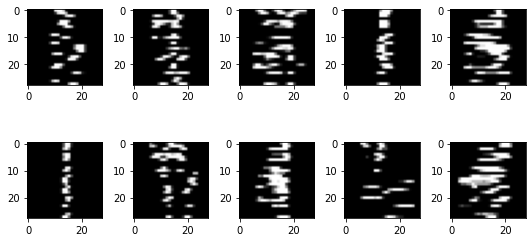

In [ ]:
#entry point, run the test harness
trainX, testX=run_test_harness()


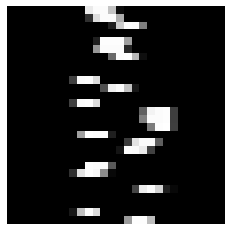

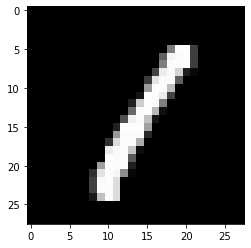

In [ ]:
permut(trainX, testX)

In [ ]:
#load an image and predict the class
def run_example(trainX, testX):
  #load the image
  #img=load_image('sample_image.png')
  #img=load_image('perm_try.png')
  trainX, testX= prep_pixels(trainX, testX)
  img=trainX[0]
  #load model
  model=load_model('final_model.h5')
  #predict the class
  predict_value=model.predict(img)
  digit=argmax(predict_value)
  print(digit)

In [ ]:
#entry point, run the example

run_example(trainX, testX)

ValueError: ignored

In [ ]:
trainX[0].shape


(28, 28, 1)

In [ ]:
def run_example_perm():
  #load the image 
  img = load_image('perm_try.png')
  #load model
  model=load_model('final_model.h5')
  #predict the class
  predict_value= model.predict(img)
  digit=argmax(predict_value)
  print(digit)

In [ ]:
run_example_perm()

3


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
